### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Load Data

In [2]:
dataframe = pd.read_csv("vote.csv")
dataframe.replace(np.NaN, "u", inplace=True) #Replace NaN with "u" (Unknown)
dataframe = pd.get_dummies(dataframe, columns=["Class"], prefix="party") #One hot encode "Class" label
dataframe

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,party_democrat,party_republican
0,n,y,n,y,y,y,n,n,n,y,u,y,y,y,n,y,0,1
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,u,0,1
2,u,y,y,u,y,y,n,n,n,n,y,n,y,y,n,n,1,0
3,n,y,y,n,u,y,n,n,n,n,y,n,y,n,n,y,1,0
4,y,y,y,n,y,y,n,n,n,n,y,u,y,y,y,y,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y,0,1
431,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y,1,0
432,n,u,n,y,y,y,n,n,n,n,y,y,y,y,n,y,0,1
433,n,n,n,y,y,y,u,u,u,u,n,y,y,y,n,y,0,1


In [3]:
#Convert Dataframe to Dataset
def df_to_ds(dataframe, selected_features, selected_targets, batch_size=32):
    features = dataframe[selected_features]
    targets = dataframe[selected_targets]
    ds = tf.data.Dataset.from_tensor_slices((dict(features), np.array(targets)))
    ds = ds.batch(batch_size)
    return ds

In [4]:
#Selected Features and Target
selected_features = [
    "handicapped-infants",
    "water-project-cost-sharing",
    "adoption-of-the-budget-resolution",
    "physician-fee-freeze",
    "el-salvador-aid",
    "religious-groups-in-schools",
    "anti-satellite-test-ban",
    "aid-to-nicaraguan-contras",
    "mx-missile",
    "immigration",
    "synfuels-corporation-cutback",
    "education-spending",
    "superfund-right-to-sue",
    "crime",
    "duty-free-exports",
    "export-administration-act-south-africa"]

selected_targets = ["party_republican", "party_democrat"]

#Feature Columns
vote_vocab_list = ["y", "n", "u"]

feature_columns = []
for f in selected_features:
    feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(f, vote_vocab_list)),)

#Create Tensorflow Datasets
train_per = 0.6
validation_per = 0.3
test_per = 0.1
batch_size = 20

train_dataframe, test_dataframe = train_test_split(dataframe, test_size=test_per)
train_dataframe, validation_dataframe = train_test_split(train_dataframe, test_size=validation_per / (1 - test_per))

train_dataset = df_to_ds(
    train_dataframe,
    selected_features,
    selected_targets,
    batch_size=batch_size)
validation_dataset = df_to_ds(
    validation_dataframe,
    selected_features,
    selected_targets,
    batch_size=batch_size)
test_dataset = df_to_ds(
    test_dataframe,
    selected_features,
    selected_targets,
    batch_size=batch_size)

### Create Models

In [5]:
linear_model = tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.05), bias_regularizer=tf.keras.regularizers.l2(0.05)),
])

linear_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

In [6]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    tf.keras.layers.Dense(10, activation=tf.nn.leaky_relu, kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(5, activation=tf.nn.leaky_relu, kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2),
])

nn_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

### Train Models

In [7]:
def plot_loss(model):
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.plot(model.history.history["loss"], label="loss")
    if("val_loss" in model.history.history.keys()):
        plt.plot(model.history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

In [8]:
def plot_accuracy(model):
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.plot(model.history.history["accuracy"], label="accuracy")
    if("val_accuracy" in model.history.history.keys()):
        plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

Epoch 1/30
13/13 - 5s - loss: 0.9728 - accuracy: 0.4423 - val_loss: 0.9149 - val_accuracy: 0.5191
Epoch 2/30
13/13 - 1s - loss: 0.8804 - accuracy: 0.5423 - val_loss: 0.8367 - val_accuracy: 0.6031
Epoch 3/30
13/13 - 1s - loss: 0.8042 - accuracy: 0.6500 - val_loss: 0.7728 - val_accuracy: 0.6794
Epoch 4/30
13/13 - 1s - loss: 0.7420 - accuracy: 0.7346 - val_loss: 0.7209 - val_accuracy: 0.7328
Epoch 5/30
13/13 - 1s - loss: 0.6913 - accuracy: 0.7577 - val_loss: 0.6785 - val_accuracy: 0.7405
Epoch 6/30
13/13 - 1s - loss: 0.6496 - accuracy: 0.7962 - val_loss: 0.6432 - val_accuracy: 0.7710
Epoch 7/30
13/13 - 1s - loss: 0.6148 - accuracy: 0.8192 - val_loss: 0.6135 - val_accuracy: 0.7939
Epoch 8/30
13/13 - 1s - loss: 0.5855 - accuracy: 0.8346 - val_loss: 0.5880 - val_accuracy: 0.8168
Epoch 9/30
13/13 - 1s - loss: 0.5603 - accuracy: 0.8385 - val_loss: 0.5660 - val_accuracy: 0.8168
Epoch 10/30
13/13 - 1s - loss: 0.5385 - accuracy: 0.8538 - val_loss: 0.5466 - val_accuracy: 0.8244
Epoch 11/30
13/13 -

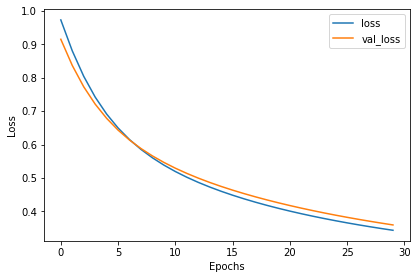

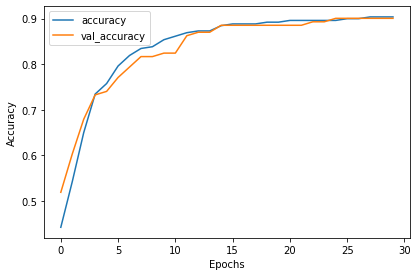

In [9]:
linear_model.fit(train_dataset, validation_data=validation_dataset, epochs=30, verbose=2)

plot_loss(linear_model)
plot_accuracy(linear_model)

Epoch 1/30
13/13 - 5s - loss: 0.8832 - accuracy: 0.6077 - val_loss: 0.8383 - val_accuracy: 0.7710
Epoch 2/30
13/13 - 1s - loss: 0.8030 - accuracy: 0.8462 - val_loss: 0.7572 - val_accuracy: 0.8855
Epoch 3/30
13/13 - 1s - loss: 0.7221 - accuracy: 0.9038 - val_loss: 0.6797 - val_accuracy: 0.8779
Epoch 4/30
13/13 - 1s - loss: 0.6470 - accuracy: 0.9038 - val_loss: 0.6179 - val_accuracy: 0.8702
Epoch 5/30
13/13 - 1s - loss: 0.5866 - accuracy: 0.9154 - val_loss: 0.5668 - val_accuracy: 0.8779
Epoch 6/30
13/13 - 1s - loss: 0.5377 - accuracy: 0.9192 - val_loss: 0.5236 - val_accuracy: 0.9008
Epoch 7/30
13/13 - 1s - loss: 0.4971 - accuracy: 0.9154 - val_loss: 0.4862 - val_accuracy: 0.9160
Epoch 8/30
13/13 - 1s - loss: 0.4628 - accuracy: 0.9154 - val_loss: 0.4553 - val_accuracy: 0.9313
Epoch 9/30
13/13 - 1s - loss: 0.4338 - accuracy: 0.9231 - val_loss: 0.4291 - val_accuracy: 0.9389
Epoch 10/30
13/13 - 1s - loss: 0.4088 - accuracy: 0.9269 - val_loss: 0.4065 - val_accuracy: 0.9389
Epoch 11/30
13/13 -

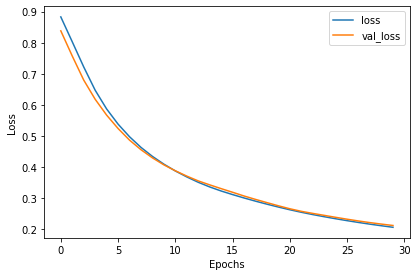

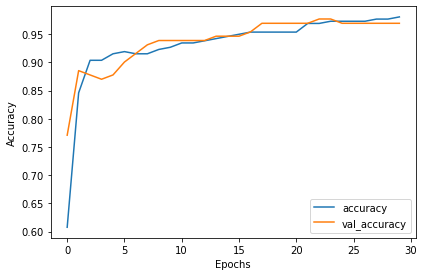

In [10]:
nn_model.fit(train_dataset, validation_data=validation_dataset, epochs=30, verbose=2)

plot_loss(nn_model)
plot_accuracy(nn_model)

### Evaluation

In [11]:
linear_model.evaluate(test_dataset)

3/3 [==============================] - 0s 54ms/step - loss: 0.3864 - accuracy: 0.8864


[0.38640570640563965, 0.8863636255264282]

In [12]:
nn_model.evaluate(test_dataset)

3/3 [==============================] - 0s 31ms/step - loss: 0.4038 - accuracy: 0.9318


[0.40382423996925354, 0.9318181872367859]

### Predictions

In [13]:
labels = test_dataframe[selected_targets].reset_index(drop=True)

In [14]:
linear_predictions = pd.DataFrame(tf.nn.softmax(linear_model.predict(test_dataset)).numpy()).join(labels)
linear_predictions.columns = ["probability_republican", "probability_democrat", "label_republican", "label_democrat"]

linear_prediction_values = linear_predictions[list(linear_predictions.columns[0:2])].idxmax(axis=1).apply(lambda x : linear_predictions.columns.get_loc(x) + 2)
linear_label_values = linear_predictions[list(linear_predictions.columns[2:4])].idxmax(axis=1).apply(lambda x : linear_predictions.columns.get_loc(x))

linear_predictions["correct"] = linear_prediction_values.combine(linear_label_values, lambda x, y : x == y)

linear_predictions

,probability_republican,probability_democrat,label_republican,label_democrat,correct
0,0.876871,0.123129,1,0,True
1,0.038540,0.961460,0,1,True
2,0.326413,0.673587,0,1,True
3,0.059710,0.940290,0,1,True
4,0.680242,0.319758,0,1,False
5,0.190727,0.809273,0,1,True
6,0.909131,0.090869,1,0,True
7,0.097338,0.902663,1,0,False
8,0.835274,0.164726,1,0,True
9,0.040141,0.959859,0,1,True


In [15]:
nn_predictions = pd.DataFrame(tf.nn.softmax(nn_model.predict(test_dataset)).numpy()).join(labels)
nn_predictions.columns = ["probability_republican", "probability_democrat", "label_republican", "label_democrat"]

nn_prediction_values = nn_predictions[list(linear_predictions.columns[0:2])].idxmax(axis=1).apply(lambda x : nn_predictions.columns.get_loc(x) + 2)
nn_label_values = nn_predictions[list(linear_predictions.columns[2:4])].idxmax(axis=1).apply(lambda x : nn_predictions.columns.get_loc(x))

nn_predictions["correct"] = nn_prediction_values.combine(nn_label_values, lambda x, y : x == y)

nn_predictions

,probability_republican,probability_democrat,label_republican,label_democrat,correct
0,0.967035,0.032965,1,0,True
1,0.006347,0.993653,0,1,True
2,0.097248,0.902752,0,1,True
3,0.029656,0.970344,0,1,True
4,0.345214,0.654786,0,1,True
5,0.013338,0.986662,0,1,True
6,0.969700,0.030300,1,0,True
7,0.134913,0.865087,1,0,False
8,0.963860,0.036140,1,0,True
9,0.014594,0.985406,0,1,True


### Backend

#### Linear

In [16]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  98        
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


In [17]:
linear_model.history.params

{'verbose': 0, 'epochs': 1, 'steps': 3}

In [18]:
for layer in linear_model.layers:
    print(layer.get_weights())

[]
[array([[ 0.00934958, -0.04384621],
       [-0.06073688, -0.07283154],
       [-0.04497688,  0.00757017],
       [-0.13505678,  0.2799046 ],
       [ 0.18714398, -0.16371876],
       [ 0.06188149, -0.09629843],
       [-0.15410429,  0.09091866],
       [ 0.2150859 ,  0.10752521],
       [ 0.0043651 ,  0.03839634],
       [-0.01319881,  0.10642646],
       [-0.15485065,  0.19157171],
       [ 0.00978307, -0.00850483],
       [-0.0590639 ,  0.32100996],
       [ 0.10617419, -0.16703996],
       [ 0.02761614, -0.06186491],
       [-0.08257681, -0.32440218],
       [-0.22952364, -0.03713522],
       [ 0.04626784, -0.0708004 ],
       [ 0.3127218 , -0.17445341],
       [-0.04789862,  0.10150094],
       [-0.09000447,  0.04075708],
       [-0.16358499,  0.11324634],
       [-0.12364671, -0.04495327],
       [-0.16948311,  0.21072662],
       [-0.05849923,  0.09331422],
       [ 0.20691468, -0.1413692 ],
       [ 0.05767366,  0.03361252],
       [-0.07094365,  0.01223457],
       [-0.21311

#### Neural Network

In [19]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  490       
_________________________________________________________________
dense_2 (Dense)              multiple                  55        
_________________________________________________________________
dense_3 (Dense)              multiple                  12        
Total params: 557
Trainable params: 557
Non-trainable params: 0
_________________________________________________________________


In [20]:
nn_model.history.params

{'verbose': 0, 'epochs': 1, 'steps': 3}

In [21]:
for layer in nn_model.layers:
    print(layer.get_weights())

[]
[array([[-1.33603781e-01,  1.39107496e-01, -9.05900635e-03,
        -2.44168967e-01, -9.97359753e-02,  1.71707615e-01,
         4.30978695e-03, -1.62861839e-01, -8.00272599e-02,
         8.02944973e-02],
       [ 2.09507331e-01,  6.15832098e-02,  3.57224024e-03,
         1.57290488e-01,  3.48869741e-01, -2.89135337e-01,
        -1.09213255e-01, -1.06786132e-01,  1.00870609e-01,
         8.33536498e-03],
       [-2.68685929e-02,  1.42495921e-02, -1.23986527e-02,
        -3.73843238e-02,  5.69089539e-02,  2.90424619e-02,
        -6.50462806e-02, -1.05845947e-02, -2.91608609e-02,
         3.56003852e-03],
       [-1.11057945e-01, -1.52544707e-01,  1.84800789e-01,
         1.60202816e-01, -1.41117722e-01, -1.20265484e-01,
        -1.17684476e-01,  7.77534917e-02, -1.26568332e-01,
         3.09257843e-02],
       [-4.21382263e-02, -5.70782609e-02,  1.40274167e-01,
         1.22953683e-01,  2.72153944e-01,  6.14705496e-02,
        -8.27849433e-02,  4.49860562e-03,  2.90591028e-02,
       